At first I'll import all the needed libraries:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Ok, now I will load given data. It's csv file, so I use read_csv.

In [3]:
df = pd.read_csv('Dane_bank_nowe.csv', sep=',')

**It is good practice to work on a copy of the data, not on the original file.** If we will edit few times original file and after 3 hours it will turn out that deleting one of the column was a mistake - working on a copy will allow us to quickly restore the column :) So..

In [4]:
df_copy = df.copy(deep = True)

### Let's see what do we have here ;)

In [5]:
df_copy.head()

,Unnamed: 0,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,886607.90,1
1,1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,916554.56,0
2,2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,849781.25,1
3,3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,1367384.50,0
4,4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,1504164.20,0


In [5]:
df_copy.duplicated().sum()

0

Ok, there are no duplicates in this file - that's good information ;)

There are few columns, which are not useful for further analysis:
* Unnamed: 0
* RowNumber
* CustomerId
* Surname (I assumed that surname has no impact had no effect on creditworthiness ;) )

So, goodbye columns!

In [6]:
to_drop = ['RowNumber', 'Surname', 'CustomerId', 'Unnamed: 0'] 
df_copy.drop(to_drop, inplace=True, axis=1)
draft_df = df_copy

Did it work?

In [7]:
draft_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,886607.90,1
1,608,Spain,Female,41,1,83807.86,1,0,1,916554.56,0
2,502,France,Female,42,8,159660.80,3,1,0,849781.25,1
3,699,France,Female,39,1,0.00,2,0,0,1367384.50,0
4,850,Spain,Female,43,2,125510.82,1,1,1,1504164.20,0


Yup, it's ok :)

In next step I'm going to check non-numeric columns and convert data into numeric. It will make work much easier and it's necessary e.g. to make chart.

In [8]:
draft_df.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [9]:
draft_df.Gender.unique()

array(['Female', 'Male'], dtype=object)

In [37]:
d = {'France':1,'Spain':2,'Germany':3, 'Female':0, 'Male':1}
final_df = df_copy.replace(d)

#For the future analysis:
all_clients = final_df

In [11]:
final_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,0,42,2,0.00,1,1,1,886607.90,1
1,608,2,0,41,1,83807.86,1,0,1,916554.56,0
2,502,1,0,42,8,159660.80,3,1,0,849781.25,1
3,699,1,0,39,1,0.00,2,0,0,1367384.50,0
4,850,2,0,43,2,125510.82,1,1,1,1504164.20,0


Much better, isn't it?

Ok, now let's see more information about data:

In [12]:
final_df.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.000000
mean,650.528800,1.749500,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,1.130141e+06,0.203700
std,96.653299,0.830433,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,3.078528e+05,0.402769
min,350.000000,1.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.914779e+05,0.000000
25%,584.000000,1.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,8.728450e+05,0.000000
50%,652.000000,1.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,1.160135e+06,0.000000
75%,718.000000,3.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,1.363969e+06,0.000000
max,850.000000,3.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,1.730501e+06,1.000000


### What can we see here? 

I think I don't have to explain what mean or standard deviation is, or how to come to any conclusion looking at these data ;) 

In this step I'm looking for any nonstandard and illogical informations, which would be a message that this data needs more "cleaning". For example:
* **minimal value of age < 18** might be due to mistake. Then, we should check how many positions with age < 18 is in the data. If there are few of them - I would delete them (all rows, not only cells) and it's ok. But it might tourned out that we have 500/10000 positions with age in the range 13-17, because bank has in its offer account for young people. And we have no column, where this information is included. Then we would have to decide what to do with it.
* **has credit card > 1** or **has credit card = 0.6** - we have separate column with number of products. The data type in this column is Boolean, so information other than 0 or 1 would be a mistake.
* **max number of products = 1872** - suspicious, right?

In the table above I don't see any illogical data. Let's move on!

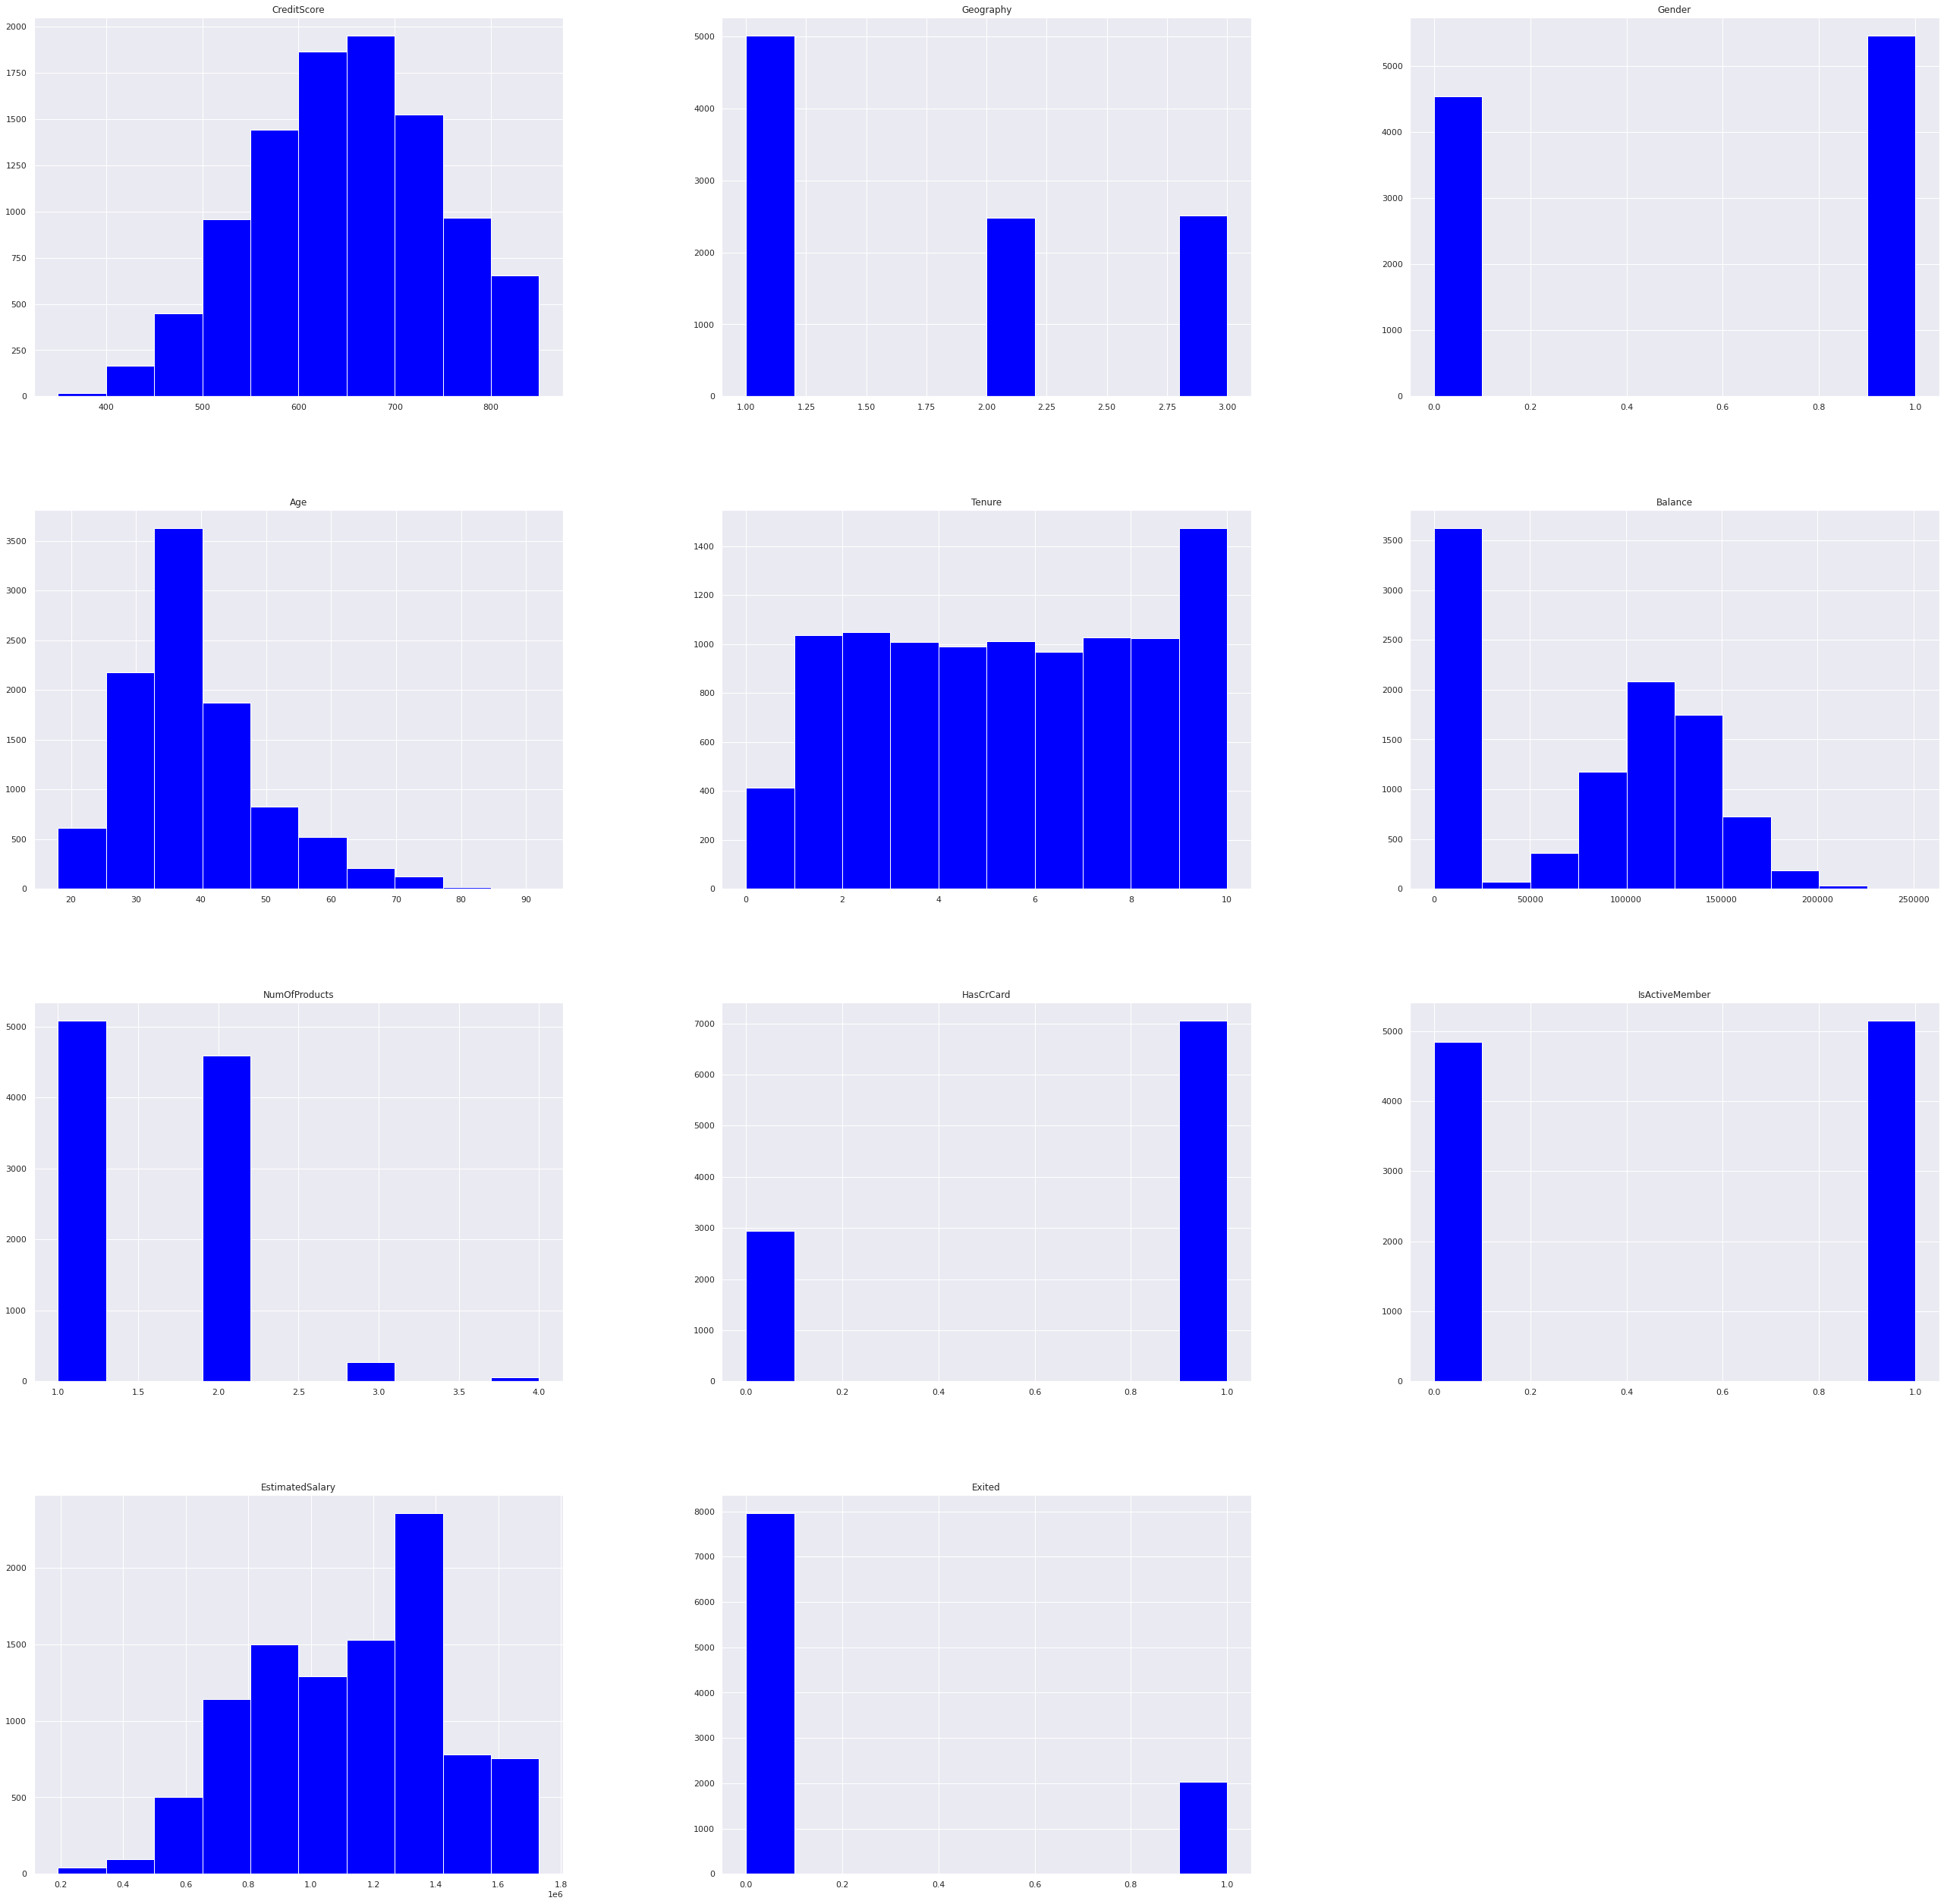

In [13]:
sns.set()
final_df.hist(figsize=(45,45), color='blue')
plt.show()

### Above plots show us some interesting things:

* the majority of clients are in the age group ~33-40
* more than 3600 clients has no money at their account (Balance = 0)
* there are around 20% exited clients
* there are more male than female clients
* almost half of clients comes from France
* around 70% of clients has credit card
* roughly the same number of customers use actively the account as not
* the most customers has one product, a bit less has two products - very few customers have 3 or more products

## What about _exited_ clients? 
_Let's compare exited and no-exited clients!_ 

#### Exited clients

In [19]:
exited = final_df[(final_df.Exited == 1)]

# we don't need 'Exited' column now:
to_drop_2 = ['Exited'] 
exited.drop(to_drop_2, inplace=True, axis=1)

exited.head()

/home/katarzyna/.local/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,1,0,42,2,0.00,1,1,1,886607.90
2,502,1,0,42,8,159660.80,3,1,0,849781.25
5,645,2,1,44,8,113755.78,2,1,0,1407073.60
7,376,3,0,29,4,115046.74,4,1,0,655831.10
16,653,3,1,58,1,132602.88,1,1,0,1475678.10


In [20]:
exited.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2.037000e+03
mean,645.351497,2.001964,0.440844,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,1.174603e+06
std,100.321503,0.893106,0.496610,9.761562,2.936106,58360.794816,0.801521,0.458776,0.480358,3.124786e+05
min,350.000000,1.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.302617e+05
25%,578.000000,1.000000,0.000000,38.000000,2.000000,38340.020000,1.000000,0.000000,0.000000,9.021529e+05
50%,646.000000,2.000000,0.000000,45.000000,5.000000,109349.290000,1.000000,1.000000,0.000000,1.216576e+06
75%,716.000000,3.000000,1.000000,51.000000,8.000000,131433.330000,2.000000,1.000000,1.000000,1.410490e+06
max,850.000000,3.000000,1.000000,84.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,1.730501e+06


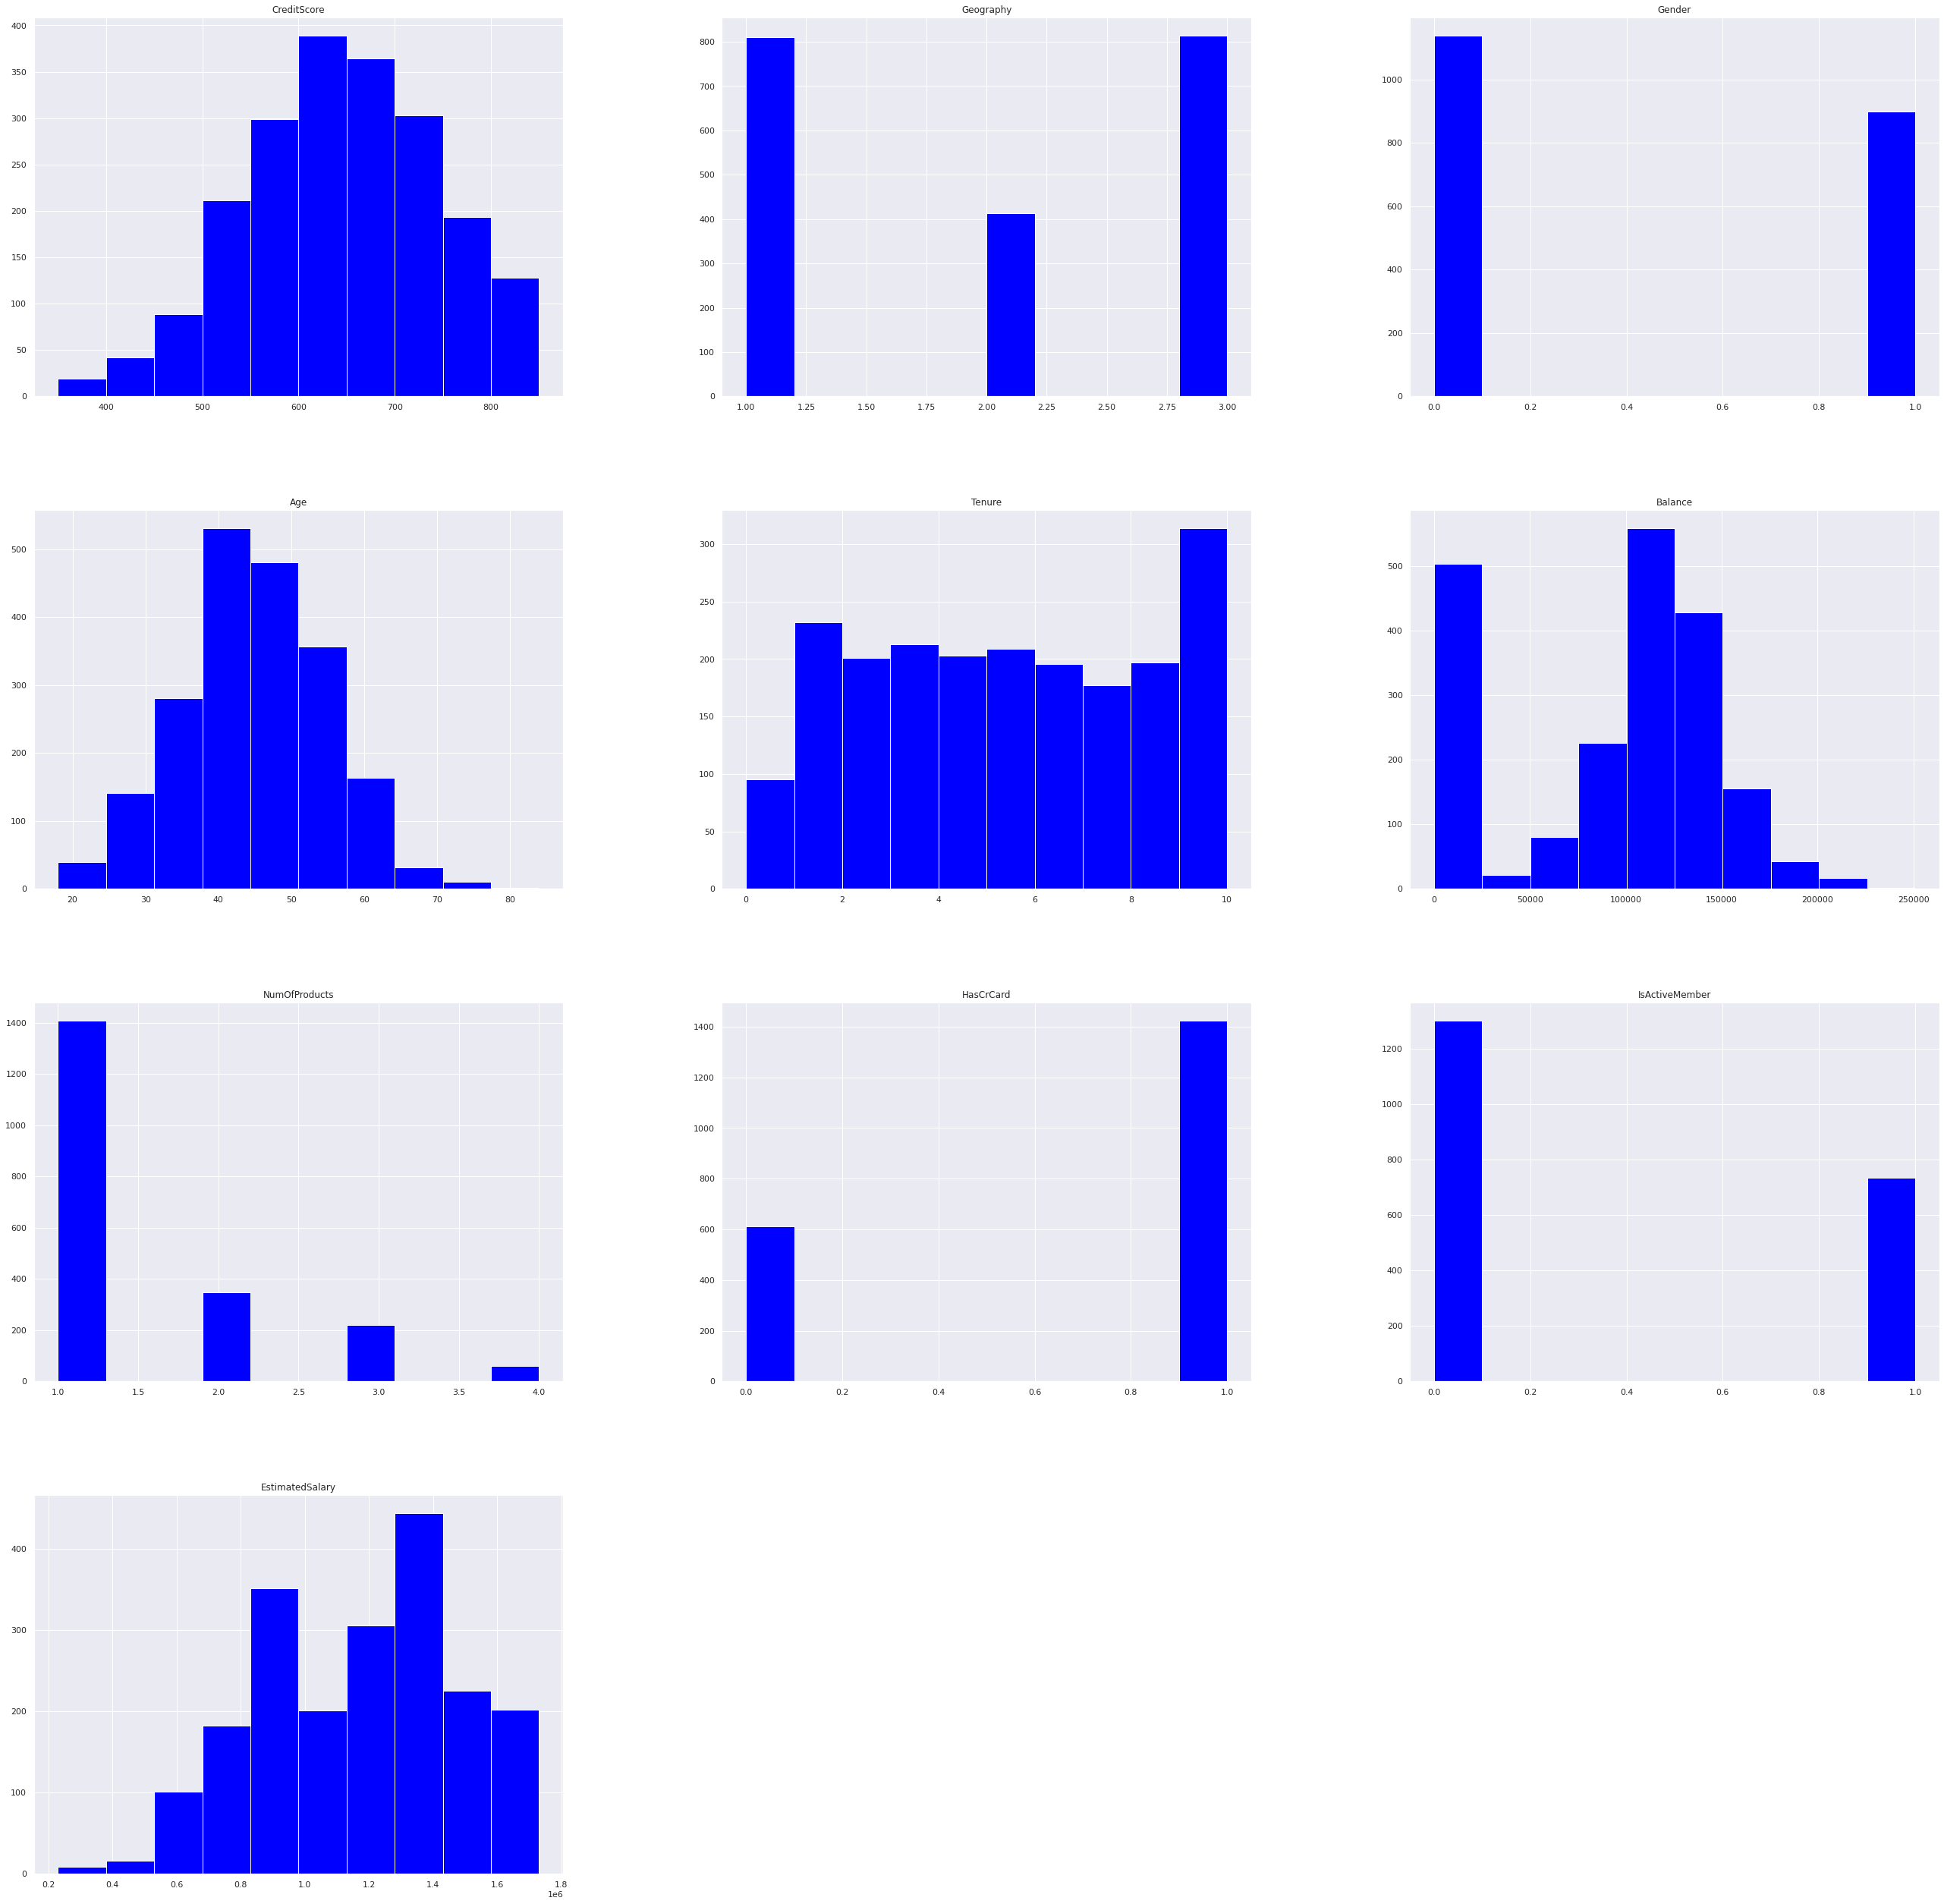

In [27]:
sns.set()
exited.hist(figsize=(45,45), color='blue')
plt.show()

#### No-exited clients

In [28]:
no_exited = final_df[(final_df.Exited == 0)]

# Again: we don't need 'Exited' column now: 
no_exited.drop(to_drop_2, inplace=True, axis=1)

no_exited.head()

/home/katarzyna/.local/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1,608,2,0,41,1,83807.86,1,0,1,916554.56
3,699,1,0,39,1,0.00,2,0,0,1367384.50
4,850,2,0,43,2,125510.82,1,1,1,1504164.20
6,822,1,1,50,7,0.00,2,1,1,1553610.60
8,501,1,1,44,4,142051.07,2,0,1,678443.60


In [29]:
no_exited.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7.963000e+03
mean,651.853196,1.684918,0.572523,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,1.118767e+06
std,95.653837,0.801002,0.494744,10.125363,2.880658,62848.040701,0.509536,0.455101,0.497045,3.056408e+05
min,405.000000,1.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.914779e+05
25%,585.000000,1.000000,0.000000,31.000000,3.000000,0.000000,1.000000,0.000000,0.000000,8.665076e+05
50%,653.000000,1.000000,1.000000,36.000000,5.000000,92072.680000,2.000000,1.000000,1.000000,1.136096e+06
75%,718.000000,2.000000,1.000000,41.000000,7.000000,126410.280000,2.000000,1.000000,1.000000,1.353339e+06
max,850.000000,3.000000,1.000000,92.000000,10.000000,221532.800000,3.000000,1.000000,1.000000,1.730501e+06


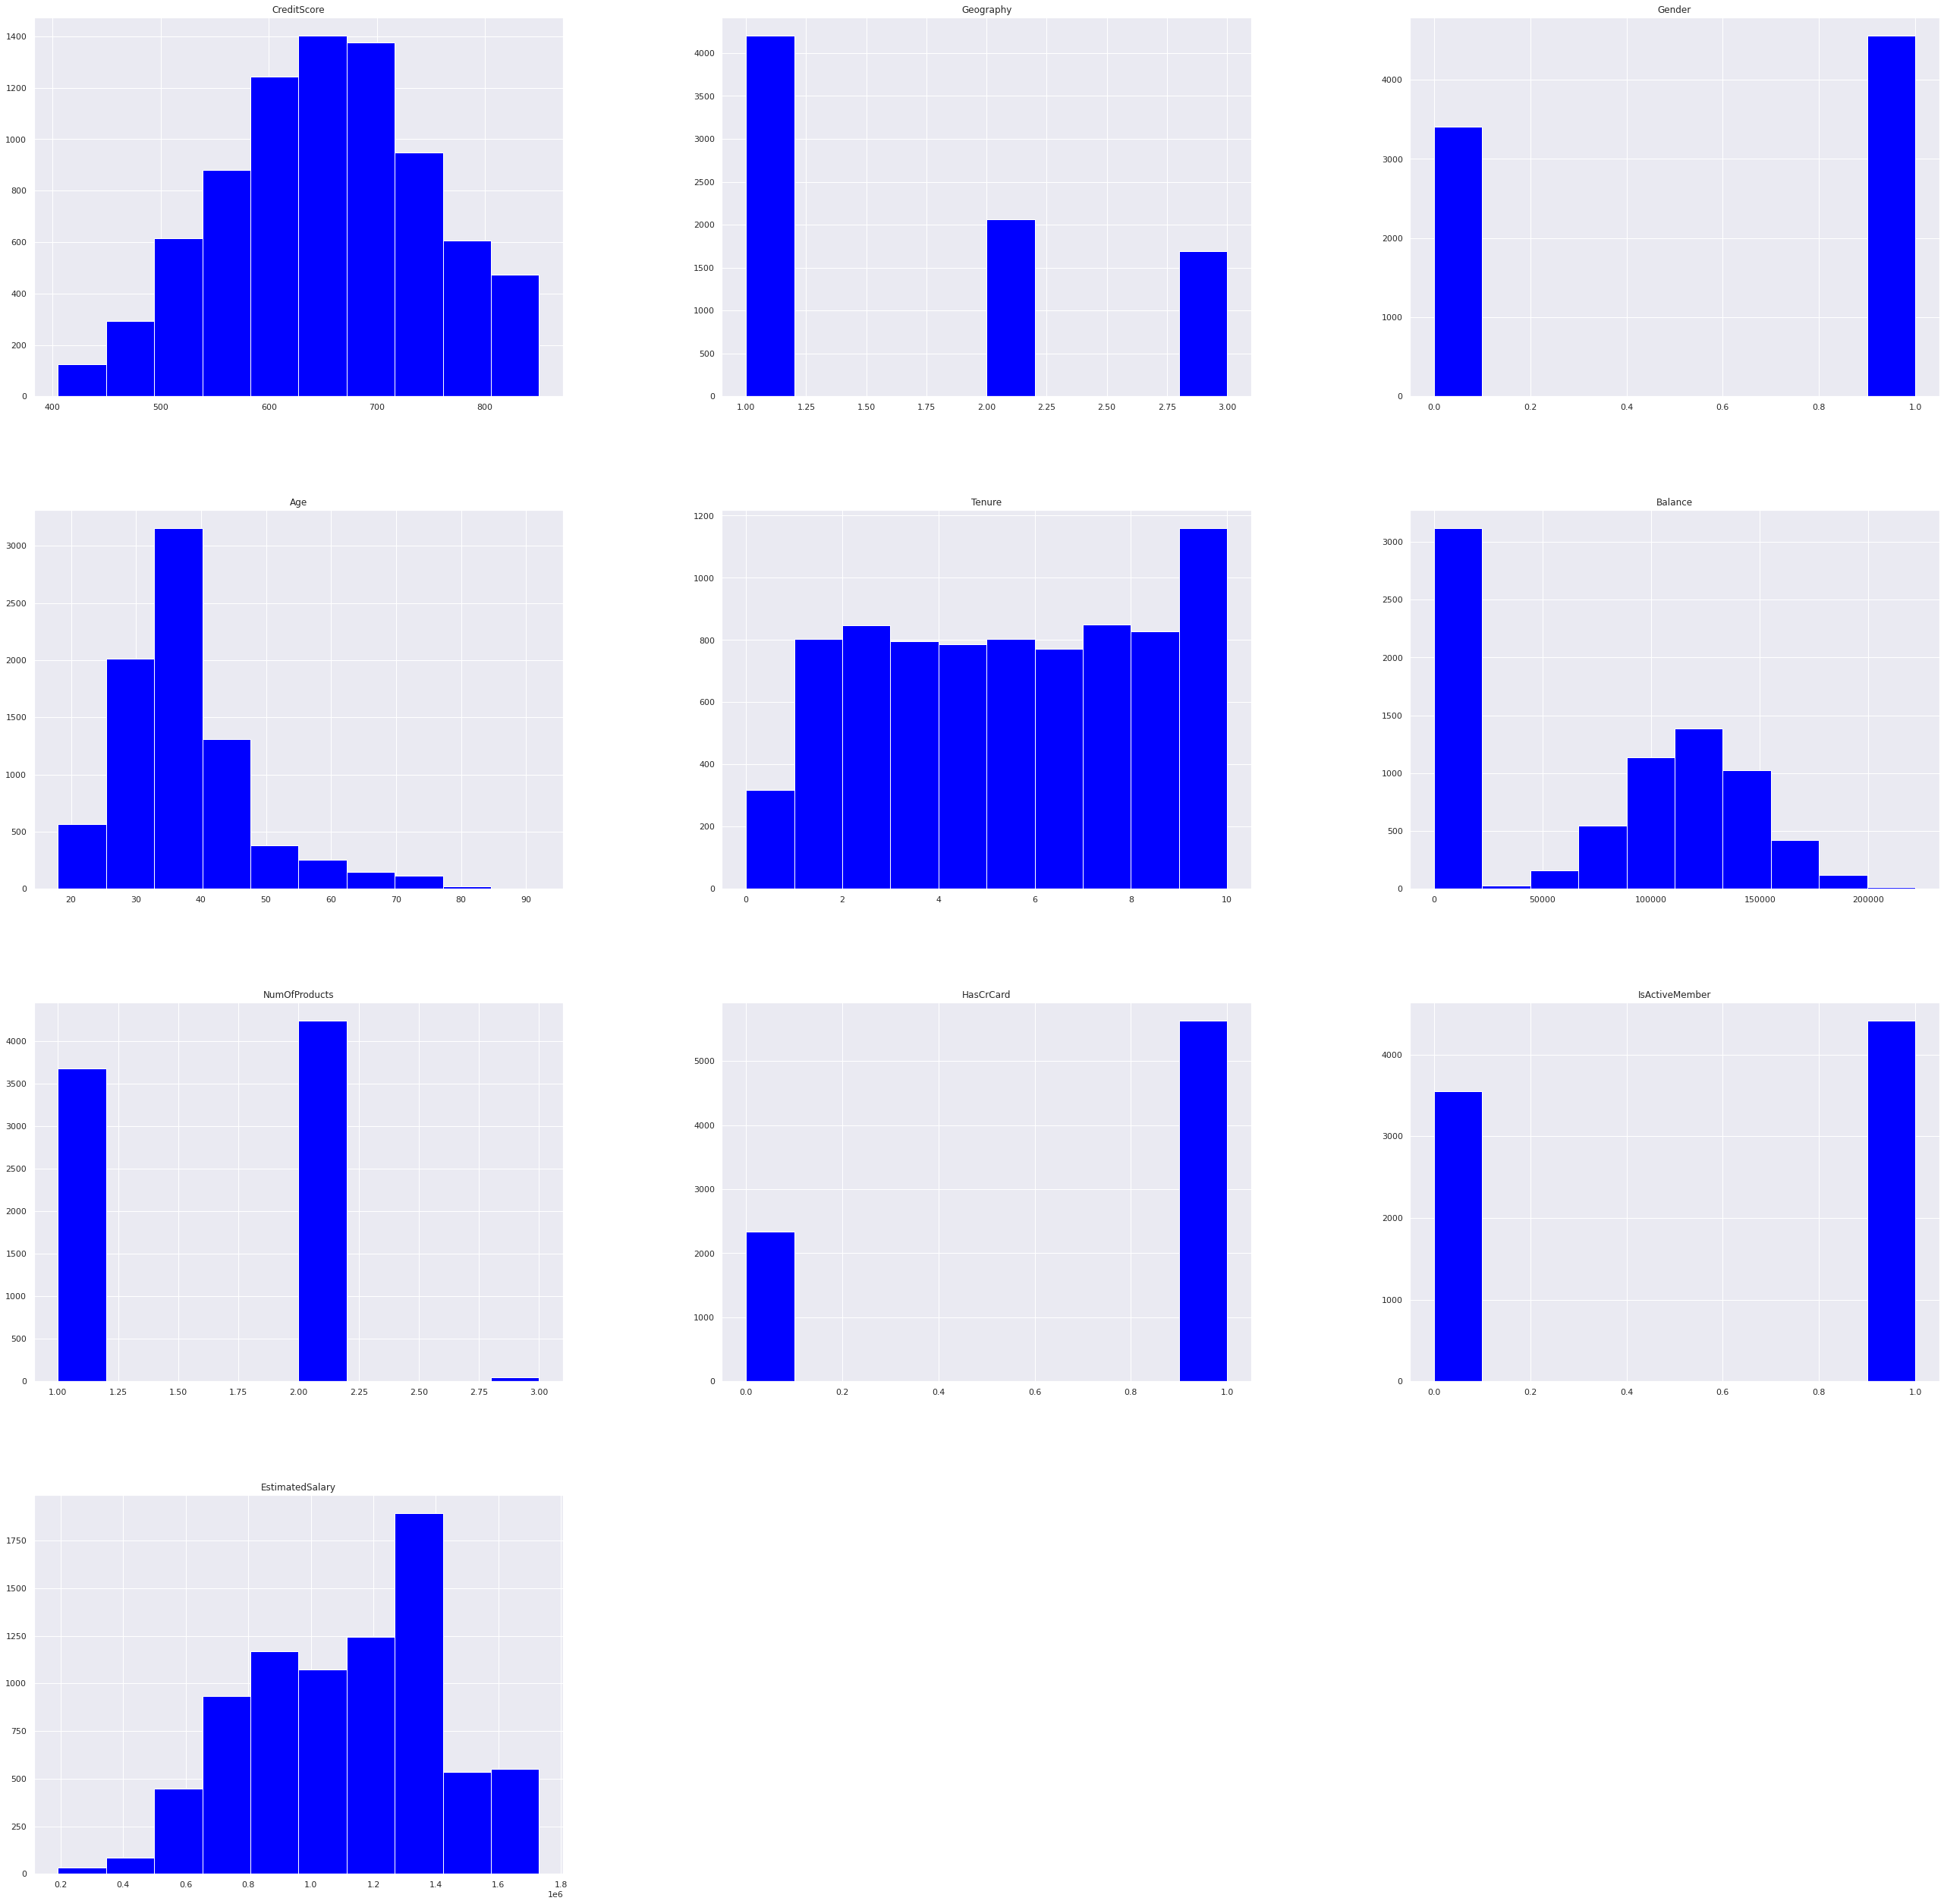

In [30]:
sns.set()
no_exited.hist(figsize=(45,45), color='blue')
plt.show()

### CreditScore

In [38]:
all_clients['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

In [35]:
exited['CreditScore'].describe()

count    2037.000000
mean      645.351497
std       100.321503
min       350.000000
25%       578.000000
50%       646.000000
75%       716.000000
max       850.000000
Name: CreditScore, dtype: float64

In [36]:
no_exited['CreditScore'].describe()

count    7963.000000
mean      651.853196
std        95.653837
min       405.000000
25%       585.000000
50%       653.000000
75%       718.000000
max       850.000000
Name: CreditScore, dtype: float64

As we can see, differences in **CreditScore** between all clients, exited clients and no-exited clients are slight. What we can observe is:
* a little lower mean for exited clients,
* minimal value for non-exited clients is 405, while for the rest of the clients it is 350.

### Geography

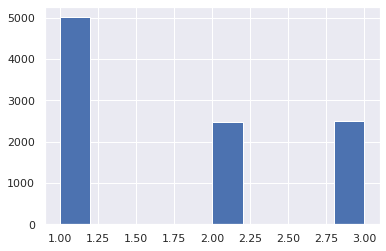

In [42]:
all_clients['Geography'].hist()

In [47]:
all_clients.Geography.value_counts()

1    5014
3    2509
2    2477
Name: Geography, dtype: int64

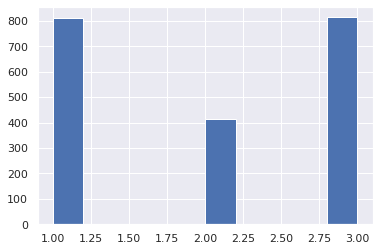

In [43]:
exited['Geography'].hist()

In [49]:
exited.Geography.value_counts()

3    814
1    810
2    413
Name: Geography, dtype: int64

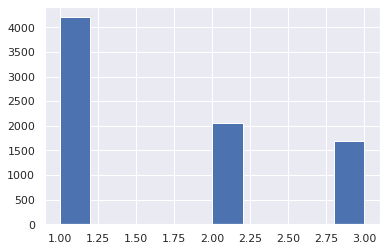

In [44]:
no_exited['Geography'].hist()

5014 of all clients is from France, a 2509 is from Germany and 2477 is from Spain. 
* 16,1% of French clients deicided to leave the bank,
* 16,7% of clients from Spain edited the bank,
* 32,4% of German clients exited the bank.

### Gender

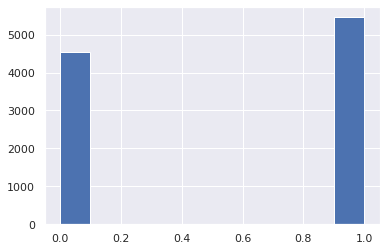

In [50]:
all_clients['Gender'].hist()

In [51]:
all_clients.Gender.value_counts()

1    5457
0    4543
Name: Gender, dtype: int64

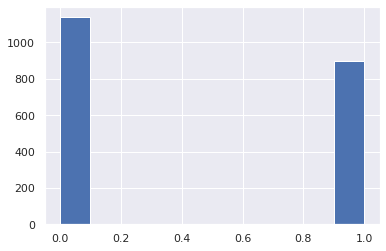

In [52]:
exited['Gender'].hist()

In [53]:
exited.Gender.value_counts()

0    1139
1     898
Name: Gender, dtype: int64

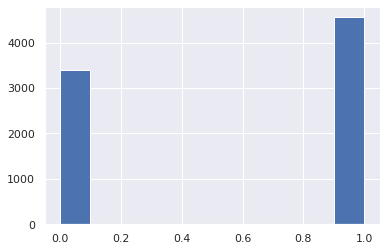

In [54]:
no_exited['Gender'].hist()

In [55]:
no_exited.Gender.value_counts()

1    4559
0    3404
Name: Gender, dtype: int64

54,57% (5457) of clients is a male, 45,43% (4543) is a female. 
* 20,3% of clients deicided to leave the bank, of which 55,9% are female,
* 25% of women and 16,5% of men exited the bank, 
* after accounting for customers who have left, the gender proportions are as follows: 57,2% of male and 42,3% of female.

### Comparison of exited and no-exited clients:
* there is no such a difference in **CreditScore**, **Tenure** and **HasCrCard** between exited and no-exited clients
* more women (55,9%) than men (44,1%) left the bank

### Now it's time to check how correlation looks like:

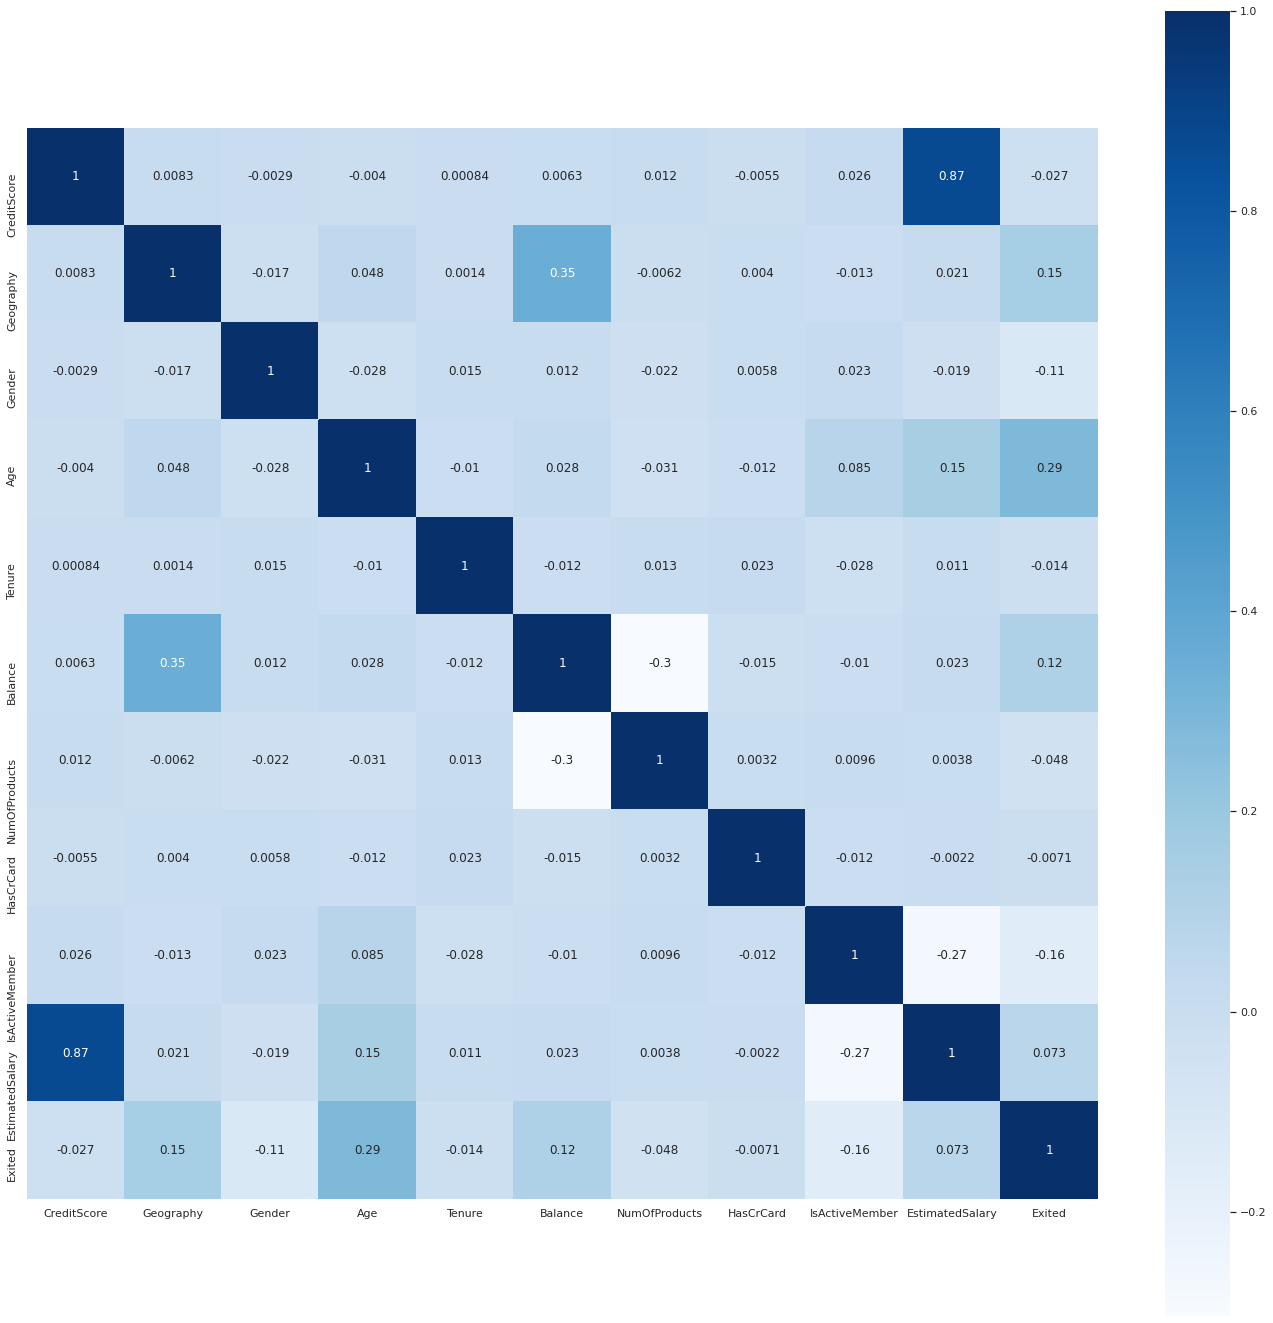

In [14]:
correlation = final_df.corr()

fig = plt.subplots(figsize=(24,24))
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap='Blues')

### Strong correlation is between:

* estimated salary and credit score: **0.87** (it's **very strong** correlation!!!)
* geography and balance: **0.35**
* balance and number of products: **-0.3**
* exited and age: **0.29**
* estimated salary and is active member: **-0.27**

### I'm going to do analysis of retention, so I will check correlation with 'exited'.

The traits strongest correlated with 'exited' are:
    * Age (0.29)
    * IsActiveMember (-0.16)
    * Geography (0.15)
And possibly:
    * Balance (0.12)
    * Gender (-0.11)
    
Are there any correlations between them (each other)?
    * Balance & Geography (0.35) <---- I should pay attention to this creating model

### Correlation between _Exited_ and _Age_ is interesting. Let's take a closer look at it:

In [15]:
check_age_cor = pd.DataFrame(final_df, columns = ['Age', 'Exited'])

In [16]:
age_cor = check_age_cor.groupby('Age').agg('count')
age_cor.head()

,Exited
Age,
18,22
19,27
20,40
21,53
22,84


Number of exited clients depending of their age


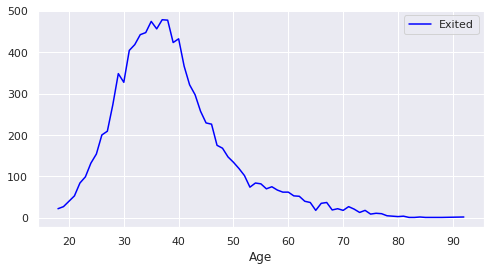

In [17]:
print("Number of exited clients depending of their age")
age_cor.plot(figsize=(8,4), color='blue')
plt.show()

As we can see, most of clients who deicided to leave the bank are in the age range 27-46.

#### Let's see distribution of our target variable (exited):

Histogram of Exited


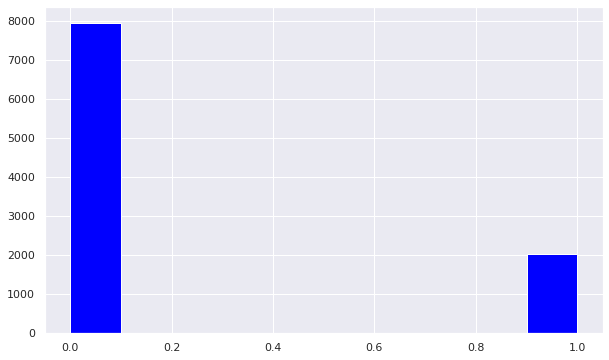

In [18]:
print("Histogram of Exited")
final_df['Exited'].hist(figsize=(10,6), color='blue')
plt.show()

We can see that distribution is not balanced. I will comment it later.

## Models

### Data preparation (defining _X_ and _y_)
All the models that I decided to use in this project will use three variants of data:
* **no.1**: all variables
* **no.2**: variables stronger correlated with _**exited**_ (Age,IsActiveMember, Geography, Balance, Gender) - here we have correlation between _Balance_ and _Geography_
* **no.3**: variables the strongest correlated with _**exited**_ (Age,IsActiveMember, Geography)

Please, remember that this dataset is **unbalanced**!!

In [19]:
# no.1
X_1 = final_df.drop('Exited', axis=1)

# no.2
X_2 = final_df[['Age','IsActiveMember', 'Geography', 'Balance', 'Gender']]

# no.3
X_3 = final_df[['Age','IsActiveMember', 'Geography']]

y = final_df['Exited']

How these data looks like?

In [20]:
X_1.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,1,0,42,2,0.00,1,1,1,886607.90
1,608,2,0,41,1,83807.86,1,0,1,916554.56
2,502,1,0,42,8,159660.80,3,1,0,849781.25
3,699,1,0,39,1,0.00,2,0,0,1367384.50
4,850,2,0,43,2,125510.82,1,1,1,1504164.20


In [21]:
X_2.head()

,Age,IsActiveMember,Geography,Balance,Gender
0,42,1,1,0.00,0
1,41,1,2,83807.86,0
2,42,0,1,159660.80,0
3,39,0,1,0.00,0
4,43,1,2,125510.82,0


In [22]:
X_3.head()

,Age,IsActiveMember,Geography
0,42,1,1
1,41,1,2
2,42,0,1
3,39,0,1
4,43,1,2


In [23]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [24]:
type(X_1), type(X_2), type(X_3), type(y)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series)

As you can see, all _X_ are DataFrames and _y_ is Series.  I will standardize it in the next step using **_.values_**.

### Function

To increase readability of my code I create function, which splits the data, fits and validates models. 
I can use it for all above data and models.

In [25]:
def split_fit_predict_score(model, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42, stratify=y)
    print("Data shapes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape, '\n')
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print("Accuracy: ", accuracy_score(y_test, y_pred), '\n') 
    
    print(classification_report(y_test, y_pred))
    
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)

## Logistic Regression

What logistic regression is? Below there are few fragments found on the [TechTarget website](https://searchbusinessanalytics.techtarget.com/definition/logistic-regression).

>_"Logistic regression is a statistical analysis method used to predict a data value based on prior observations of a data set. (...) The approach allows an algorithm being used in a machine learning application to classify incoming data based on historical data. As more relevant data comes in, the algorithm should get better at predicting classifications within data sets. Logistic regression can also play a role in data preparation activities by allowing data sets to be put into specifically predefined buckets during the extract, transform, load (ETL) process in order to stage the information for analysis."_

>_"A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables."_

>_"Logistic regression is one of the most commonly used machine learning algorithms for binary classification problems, which are problems with two class values, including predictions such as “this or that,” “yes or no” and “A or B.” "_

>_"The purpose of logistic regression is to estimate the probabilities of events, including determining a relationship between features and the probabilities of particular outcomes."_

In our model we have binary classification: we should predict if client is going to exite (1) or not (0). 
So, first model which I want to check out is logistic regression :)

**what else is important when we are going to use logistic regression model?**

* only independent variables that have a significant impact on the dependent variable should be included in the model,
* independent variables must be independent of each other (uncorrelated),
* logistic regression requires large size of sample.

### Logistic regression parameters

According the scikit learn documentation, logistic regression model has following parameters: 

* **penalty** : {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
* **dual** : bool, default=False
* **tol** : float, default=1e-4
* **C** : float, default=1.0
* **fit_intercept** : bool, default=True
* **intercept_scaling** : float, default=1
* **class_weight** : dict or ‘balanced’, default=None
* **random_state** : int, RandomState instance, default=None
* **solver** : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
* **max_iter** : int, default=100
* **multi_class** : {‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’
* **verbose** : int, default=0
* **warm_start** : bool, default=False
* **n_jobs** : int, default=None
* **l1_ratio** : float, default=None

### _Few words about splitting data into training and testing set._

**Training set** is the most important - this is what our model learns from. However, the size of this set should not be too large. In that case, our model can be **overtrained**. This means, that model can fit well with the training data, but applied to data not encountered during learning, will give worse results. In the picture below you can see how it works (green line).



**Testing set** is a separate set of data, that the model has not dealt with during learning. Thanks to it, we can test how our model works.

There could be also **validation set**, but this time I'll skip it. 

For the purposes of this project, I used the following proportions:
* **Training dataset = 0.8**
* **Test dataset = 0.2**

### Logistic Regression - all variables (no.1)

In [26]:
logreg_model = LogisticRegression()

Data shapes:  (8000, 10) (2000, 10) (8000,) (2000,) 

Accuracy:  0.7965 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



/home/katarzyna/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


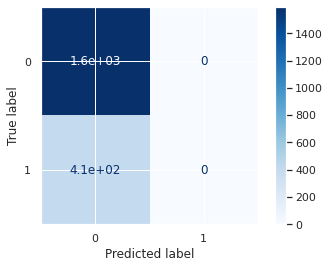

In [27]:
split_fit_predict_score(logreg_model, X_1, y)

## Metrics

Logistic regression model is a classifier, so I evaluate it using the metrics designed to evaluate the classifiers:
* confusion matrix
* recall
* precision
* accuracy
* F1 score

#### How these metrics work? How to interpret their values?

### Confusion matrix

It is a special kind of contingency table, with two dimensions ("actual" and "predicted"), and identical sets of "classes" in both dimensions (each combination of dimension and class is a variable in the contingency table).

![alt text](http://mathspace.pl/wp-content/uploads/2015/10/ConfusionMatrix.png)

### Recall and Precision

These metrics are based on confusion matrix in the way described on the picture below (you can find it and read more on the [Wikipedia website](https://en.wikipedia.org/wiki/Precision_and_recall).

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

![alt text](https://lawtomated.com/wp-content/uploads/2019/10/Recall_1-585x133.png)

![alt text](https://lawtomated.com/wp-content/uploads/2019/10/Precision_1-585x163.png)

### Accuracy

This metric we can also count using confusion matrix:
    
![alt text](https://lawtomated.com/wp-content/uploads/2019/10/Accuracy_1.png)

In oder words, we can describe it in this way:

![alt text](https://lawtomated.com/wp-content/uploads/2019/10/Accuracy_2-585x130.png)

Accuracy is simple to use and to understand, but we shouldn't use it if we have unbalanced dataset. In that case accuracy value might be misleading.

### F1 Score

As we can read at [LaptrinhX Website](https://laptrinhx.com/accuracy-precision-recall-and-f1-scores-for-lawyers-3883682331/):

>_"The F1 Score is the weighted average (or harmonic mean) of Precision and Recall. Therefore, this score takes both False Positives and False Negatives into account to strike a balance between precision and Recall."_

![alt text](https://lawtomated.com/wp-content/uploads/2019/10/F1-Score-585x147.png)

### Logistic Regression - variables stronger correlated with 'Exited'  (no.2)
Remember, that one pair of variables has correlation 0.35. I would like to show the impact of this correlation.

In [28]:
logreg_model = LogisticRegression()

Data shapes:  (8000, 5) (2000, 5) (8000,) (2000,) 

Accuracy:  0.7965 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



/home/katarzyna/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


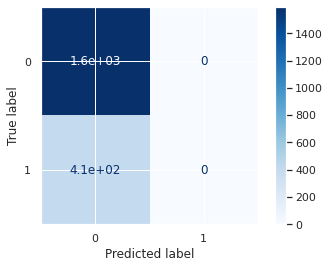

In [29]:
split_fit_predict_score(logreg_model, X_2, y)

### Logistic Regression - variables the strongest correlated with 'Exited'  (no.3)

Data shapes:  (8000, 3) (2000, 3) (8000,) (2000,) 

Accuracy:  0.8095 

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1593
           1       0.62      0.16      0.25       407

    accuracy                           0.81      2000
   macro avg       0.72      0.57      0.57      2000
weighted avg       0.78      0.81      0.76      2000



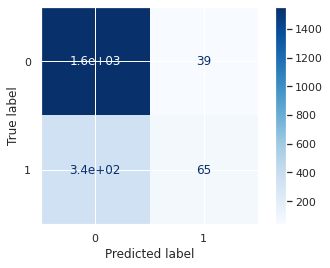

In [30]:
split_fit_predict_score(logreg_model, X_3, y)

### Logistic Regression - results

| Metrics | No.1 | No.2 | No.3 |
| :-: | :-: | :-: | :-: |
| Accuracy | 0.7965 | 0.7965 | 0.8095 |
| Precision | 0: 0.80<br>1: 0.00 | 0: 0.80<br>1: 0.00 | 0: 0.82<br>1: 0.62 |
| Recall | 0: 1.00<br>1: 0.00 | 0: 1.00<br>1: 0.00 | 0: 0.98<br>1: 0.16 |
| F1 | 0: 0.89<br> 1: 0.00 | 0: 0.89<br> 1: 0.00 | 0: 0.89<br>1: 0.25 |

_At the beginning I will mark, that in this case we shouldn't look at Accuracy value - I remind that dataset is unbalanced._

_As we can see, there is no difference in results between variant no.1 and no.2._

## Decision Tree

Simply description what decision tree is we can find at [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree):

>_A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements._

How it works we can see below :)

![alt text](https://i.imgur.com/1MD7ptT.png)

Using decision tree model we should remember that this model is sensitive to **overtraining**. The action which is necessery to prevent  overtraining is called **pruning**. We can do this by manipulating the model parameters, especially:

* _**max_depth**_ - maximum depth of tree,
* _**min_samples_split**_ - minimum number of samples in a node to be further split,
* _**min_samples_leaf**_ - minimum number of samples in leaf (an external node),
* _**max_leaf_nodes**_ - maximum number of leaf nodes is reached,
* _**min_impurity_decrease**_ - sets a threshold on the impurity decrease to consider a partition (takes values from 0 to 1).

Usually there is no need (and sense) to use all above parameters in the same time - they have a similar purpose: to prune the tree. It is recommended to use two of them in one model.

#### How to optimize our model using above parameters? 

We can choose parameters based on our knowledge and experience, or.. We can write a loop, which finds optimal parameters for data we work with. This process is called **Grid Search**. 

We can do this using _GridSearchCV,_ but I'll write my own function by hand - just for practice :) 

_This is not exactly GridSearch function - that one should have nested loops._ 

I've chosen 3 parameters: **criterion** and two pruning ones - **max_depth** and **min_samples_leaf**.

In [31]:
criterion_list = ['gini', 'entropy']
max_depth_list = [2, 6, 10, 15, 22, 37, 56, 68, 80, 95, 100, 115, 128, 150, 170]
min_samples_leaf_list = [5, 10, 20, 25, 40, 60, 80, 100, 125, 160]

criterion_scores = {}
max_depth_scores = {}
min_samples_leaf_scores = {}

In [32]:
def dt_optimal_parameters_function(X, y):
    
    X_train,X_test,y_train,y_test = train_test_split(X ,y ,test_size=0.2, random_state=42, stratify=y)
    
    for i in criterion_list:
        dt_model = DecisionTreeClassifier(criterion=i)
        dt_model.fit(X_train, y_train)
        dt_score = dt_model.score(X_test, y_test)
        
        criterion_scores[i] = dt_score
        
    best_criterion = max(criterion_scores.items())[0] 
    print("Best critetion: ", best_criterion)
    
    for i in max_depth_list:
        dt_model = DecisionTreeClassifier(criterion=best_criterion, max_depth=i)
        dt_model.fit(X_train, y_train)
        dt_score = dt_model.score(X_test, y_test)
        
        max_depth_scores[i] = dt_score
        
    best_max_depth = max(max_depth_scores.items(), key=lambda item: item[1])
    print("Best max_depth: ", best_max_depth[0])
        
    for i in min_samples_leaf_list:
        dt_model = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth[0], 
                                          min_samples_leaf=i)
        dt_model.fit(X_train, y_train)
        dt_score = dt_model.score(X_test, y_test)
        
        min_samples_leaf_scores[i] = dt_score
        
    best_min_samples_leaf = max(min_samples_leaf_scores.items(), key=lambda item: item[1])
    print("Best min_samples_leaf: ", best_min_samples_leaf[0])

### Decision Tree - all variables (no.1)

In [33]:
dt_optimal_parameters_function(X_1,y)

Best critetion:  gini
Best max_depth:  6
Best min_samples_leaf:  10


In [34]:
dt_model_no1 = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_leaf=10)

Data shapes:  (8000, 10) (2000, 10) (8000,) (2000,) 

Accuracy:  0.86 

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.78      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



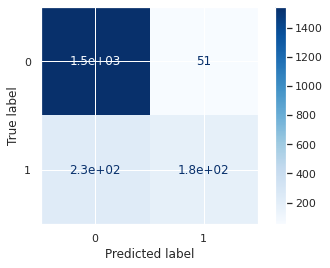

In [35]:
split_fit_predict_score(dt_model_no1, X_1, y)

### Decision Tree - variables stronger correlated with 'Exited'  (no.2)

In [36]:
dt_optimal_parameters_function(X_2,y)

Best critetion:  gini
Best max_depth:  6
Best min_samples_leaf:  40


In [37]:
dt_model_no2 = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_leaf=40)

Data shapes:  (8000, 5) (2000, 5) (8000,) (2000,) 

Accuracy:  0.834 

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1593
           1       0.70      0.33      0.44       407

    accuracy                           0.83      2000
   macro avg       0.77      0.65      0.67      2000
weighted avg       0.82      0.83      0.81      2000



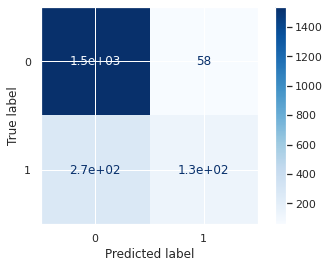

In [38]:
split_fit_predict_score(dt_model_no2, X_2, y)

### Decision Tree - variables the strongest correlated with 'Exited'  (no.3)

In [39]:
dt_optimal_parameters_function(X_3,y)

Best critetion:  gini
Best max_depth:  10
Best min_samples_leaf:  10


In [40]:
dt_model_no3 = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=10)

Data shapes:  (8000, 3) (2000, 3) (8000,) (2000,) 

Accuracy:  0.8305 

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1593
           1       0.70      0.30      0.42       407

    accuracy                           0.83      2000
   macro avg       0.77      0.63      0.66      2000
weighted avg       0.81      0.83      0.80      2000



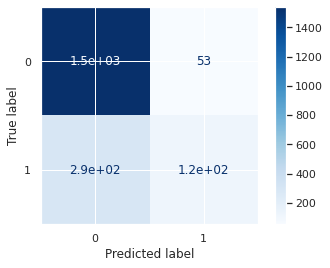

In [41]:
split_fit_predict_score(dt_model_no3, X_3, y)

## Now, I'm going to use GridSearchCV and compare results with my own function!

In [42]:
dt_parameters = {'criterion':['gini','entropy'], 'max_depth':max_depth_list, 
                 'min_samples_leaf':min_samples_leaf_list}

In [43]:
dt_gridsearch = GridSearchCV(DecisionTreeClassifier(), dt_parameters, cv=5)

### Decision Tree - all variables (no.1) - using GridSearchCV

Data shapes:  (8000, 10) (2000, 10) (8000,) (2000,) 

Accuracy:  0.86 

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.77      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



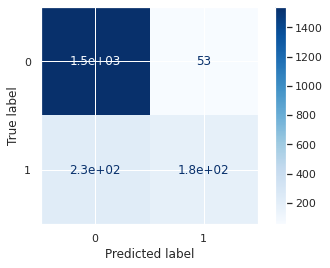

In [44]:
split_fit_predict_score(dt_gridsearch, X_1, y)

### Decision Tree - variables stronger correlated with 'Exited' (no.2) - using GridSearchCV

Data shapes:  (8000, 5) (2000, 5) (8000,) (2000,) 

Accuracy:  0.834 

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1593
           1       0.68      0.35      0.46       407

    accuracy                           0.83      2000
   macro avg       0.77      0.65      0.68      2000
weighted avg       0.82      0.83      0.81      2000



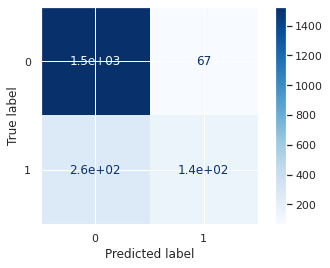

In [45]:
split_fit_predict_score(dt_gridsearch, X_2, y)

### Decision Tree - variables the strongest correlated with 'Exited'  (no.3) - using GridSearchCV

Data shapes:  (8000, 3) (2000, 3) (8000,) (2000,) 

Accuracy:  0.827 

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1593
           1       0.68      0.29      0.40       407

    accuracy                           0.83      2000
   macro avg       0.76      0.63      0.65      2000
weighted avg       0.81      0.83      0.80      2000



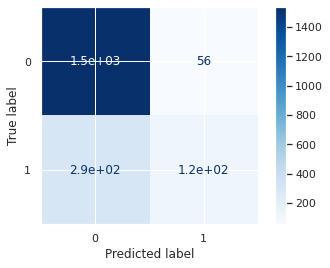

In [46]:
split_fit_predict_score(dt_gridsearch, X_3, y)

## Let's compare the results!

### Decision Tree - results

| Metrics | No. 1 | No. 1 - GridSearch | No. 2 | No. 2 - GridSearch | No. 3 | No. 3 - GridSearch | 
| :- | :-: | :-: | :-: | :-: | :-: | :-: |
| Accuracy | 0.86 | 0.86 | 0.834 | 0.834 | 0.8305 | 0.827 |
| Precision | 0: 0.87<br>1: 0.78 | 0: 0.87<br>1: 0.77 | 0: 0.85<br>1: 0.70 | 0: 0.85<br>1: 0.68 | 0: 0.84<br>1: 0.70 | 0: 0.84<br>1: 0.68 |  
| Recall | 0: 0.97<br>1: 0.44 | 0: 0.97<br>1: 0.44 | 0: 0.96<br>1: 0.33 | 0: 0.96<br>1: 0.35 | 0: 0.97<br>1: 0.30 | 0: 0.96<br>1: 0.29 | 
| F1 | 0: 0.92<br>1: 0.56 | 0: 0.92<br>1: 0.56 | 0: 0.90<br>1: 0.44 | 0: 0.90<br>1: 0.46 | 0: 0.90<br>0: 0.42 |  0: 0.90<br>0: 0.40 |

_We obtained the best results using all variables in Decision Tree model._ 

_Comparing my proprietary function with the built-in GridSearchCV, you can see slight differences. 
What suprised me, more in favor of my function than GridSearchCV!_ :o 

### Logistic Regression - results 

| Metrics | No.1 | No.2 | No.3 |
| :-: | :-: | :-: | :-: |
| Accuracy | 0.7965 | 0.7965 | 0.8095 |
| Precision | 0: 0.80<br>1: 0.00 | 0: 0.80<br>1: 0.00 | 0: 0.82<br>1: 0.62 |
| Recall | 0: 1.00<br>1: 0.00 | 0: 1.00<br>1: 0.00 | 0: 0.98<br>1: 0.16 |
| F1 | 0: 0.89<br> 1: 0.00 | 0: 0.89<br> 1: 0.00 | 0: 0.89<br>1: 0.25 |

_As we can see, Decision Tree Classifier is better model for this dataset._

In the next step I will check Random Forest model - I expect slightly better results than DT.


## Random Forest

The last model which I'm going to use is Random Forest Classifier. 

In this model we create kind of Forest, consisting of many Decision Trees. Because of that, the possibility of overtraining decreases. 

In Random Forest **each tree is only trained on a random subset of samples drawn from the training set** (with repetition) and possibly a random subset of features.

Many parameters used in this model I already described in Decision Tree section. Parameter which occurs only in Random Forest is called **n_estimators** and determines the number of trees in the forest.

_This time I'm going to use only GridSearchCV and compare results with all of the above._

In [47]:
n_estimators_list = [2, 15, 45, 77, 100, 120]
max_depth_list_rf = [2, 6, 15, 37, 68, 95, 115, 150]

In [48]:
rf_parameters = {'n_estimators':n_estimators_list, 'criterion':['gini','entropy'], 'max_depth':max_depth_list_rf}

In [49]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(), rf_parameters, cv=5)

### Random Forest - all variables (no.1)

Data shapes:  (8000, 10) (2000, 10) (8000,) (2000,) 

Accuracy:  0.858 

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.75      0.46      0.57       407

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.74      2000
weighted avg       0.85      0.86      0.84      2000



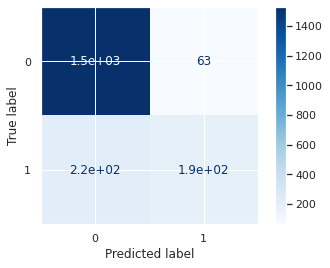

In [50]:
split_fit_predict_score(rf_gridsearch, X_1, y)

### Random Forest - variables stronger correlated with 'Exited' (no.2)

Data shapes:  (8000, 5) (2000, 5) (8000,) (2000,) 

Accuracy:  0.835 

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1593
           1       0.72      0.31      0.44       407

    accuracy                           0.83      2000
   macro avg       0.78      0.64      0.67      2000
weighted avg       0.82      0.83      0.81      2000



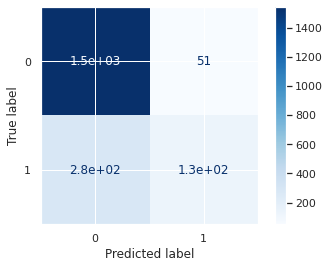

In [51]:
split_fit_predict_score(rf_gridsearch, X_2, y)

### Random Forest - variables the strongest correlated with 'Exited'  (no.3)

Data shapes:  (8000, 3) (2000, 3) (8000,) (2000,) 

Accuracy:  0.83 

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1593
           1       0.69      0.30      0.42       407

    accuracy                           0.83      2000
   macro avg       0.76      0.63      0.66      2000
weighted avg       0.81      0.83      0.80      2000



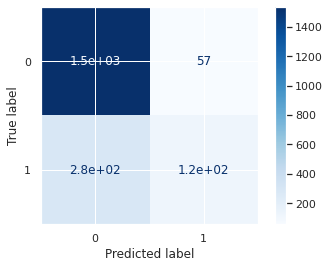

In [52]:
split_fit_predict_score(rf_gridsearch, X_3, y)

## What if our dataset would be balanced?
Let's check it out!

I'll use _GridSearchCV_ in Decision Tree and Random Forest models.  

I need to edit a bit _**split_fir_predict_score**_ function. 

In [55]:
def balance_split_fit_predict_score(model, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                        stratify=y)
    #in this part of function training dataset gets balanced 
    train = pd.concat([X_train, y_train], axis=1)
    train_1 = train.loc[train['Exited']==1]
    train = pd.concat([train, train_1, train_1, train_1])
    
    print("Data shapes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape, '\n')
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print("Accuracy: ", accuracy_score(y_test, y_pred), '\n') 
    
    print(classification_report(y_test, y_pred))
    
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)

### Logistic Regression - all variables (no.1) - _BALANCED DATASET!_

Data shapes:  (8000, 10) (2000, 10) (8000,) (2000,) 

Accuracy:  0.7965 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



/home/katarzyna/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


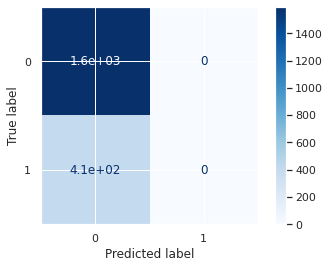

In [56]:
balance_split_fit_predict_score(logreg_model, X_1, y)

### Logistic Regression - variables stronger correlated with 'Exited'  (no.2) - _BALANCED DATASET!_

Data shapes:  (8000, 5) (2000, 5) (8000,) (2000,) 

Accuracy:  0.7965 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000



/home/katarzyna/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


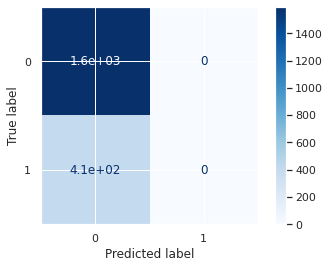

In [57]:
balance_split_fit_predict_score(logreg_model, X_2, y)

### Logistic Regression - variables the strongest correlated with 'Exited'  (no.3) -  _BALANCED DATASET!_

Data shapes:  (8000, 3) (2000, 3) (8000,) (2000,) 

Accuracy:  0.8095 

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1593
           1       0.62      0.16      0.25       407

    accuracy                           0.81      2000
   macro avg       0.72      0.57      0.57      2000
weighted avg       0.78      0.81      0.76      2000



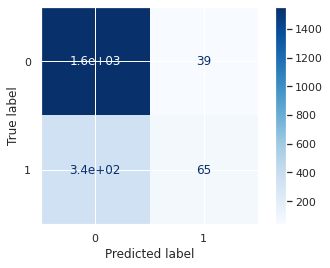

In [58]:
balance_split_fit_predict_score(logreg_model, X_3, y)

### Decision Tree - all variables (no.1) - _BALANCED DATASET!_

Data shapes:  (8000, 10) (2000, 10) (8000,) (2000,) 

Accuracy:  0.86 

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.77      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



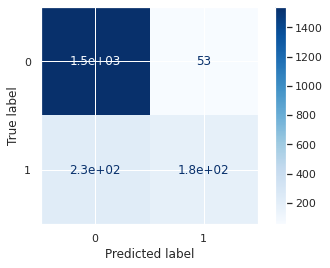

In [59]:
balance_split_fit_predict_score(dt_gridsearch, X_1, y)

### Decision Tree - variables stronger correlated with 'Exited'  (no.2)  - _BALANCED DATASET!_

Data shapes:  (8000, 5) (2000, 5) (8000,) (2000,) 

Accuracy:  0.834 

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1593
           1       0.68      0.35      0.46       407

    accuracy                           0.83      2000
   macro avg       0.77      0.65      0.68      2000
weighted avg       0.82      0.83      0.81      2000



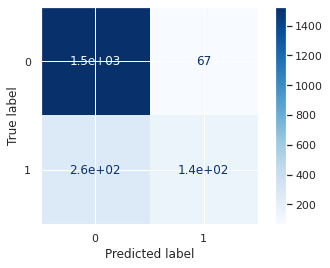

In [60]:
balance_split_fit_predict_score(dt_gridsearch, X_2, y)

### Decision Tree - variables the strongest correlated with 'Exited'  (no.3) - _BALANCED DATASET!_

Data shapes:  (8000, 3) (2000, 3) (8000,) (2000,) 

Accuracy:  0.827 

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1593
           1       0.68      0.29      0.40       407

    accuracy                           0.83      2000
   macro avg       0.76      0.63      0.65      2000
weighted avg       0.81      0.83      0.80      2000



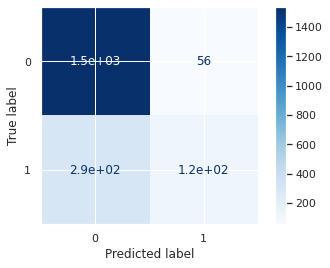

In [61]:
balance_split_fit_predict_score(dt_gridsearch, X_3, y)

### Random Forest - all variables (no.1) - _BALANCED DATASET!_

Data shapes:  (8000, 10) (2000, 10) (8000,) (2000,) 

Accuracy:  0.8575 

              precision    recall  f1-score   support

           0       0.88      0.96      0.91      1593
           1       0.73      0.47      0.58       407

    accuracy                           0.86      2000
   macro avg       0.80      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000



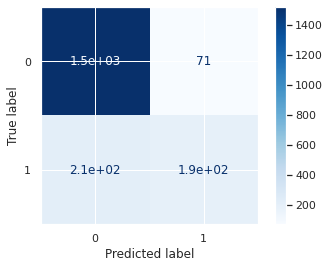

In [62]:
balance_split_fit_predict_score(rf_gridsearch, X_1, y)

### Random Forest - variables stronger correlated with 'Exited'  (no.2)  - _BALANCED DATASET!_

Data shapes:  (8000, 5) (2000, 5) (8000,) (2000,) 

Accuracy:  0.835 

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1593
           1       0.71      0.32      0.44       407

    accuracy                           0.83      2000
   macro avg       0.78      0.64      0.67      2000
weighted avg       0.82      0.83      0.81      2000



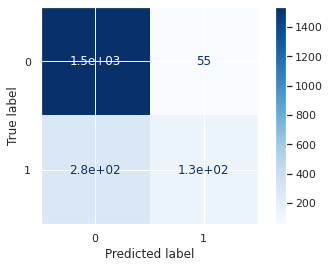

In [63]:
balance_split_fit_predict_score(rf_gridsearch, X_2, y)

### Random Forest - variables the strongest correlated with 'Exited'  (no.3) - _BALANCED DATASET!_

Data shapes:  (8000, 3) (2000, 3) (8000,) (2000,) 

Accuracy:  0.83 

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1593
           1       0.69      0.30      0.42       407

    accuracy                           0.83      2000
   macro avg       0.77      0.63      0.66      2000
weighted avg       0.81      0.83      0.80      2000



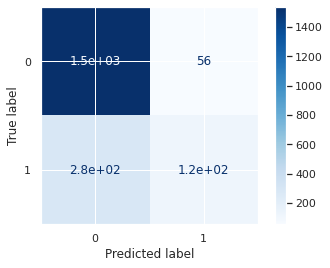

In [64]:
balance_split_fit_predict_score(rf_gridsearch, X_3, y)

# SUMMARY

## _RESULTS - Comparison of models_

| Metrics | LR no.1 | LR no.2 | LR no.3 | DT*** no.1 | DT*** no.2 | DT*** no.3 | RF no.1 | RF no.2 | RF no.3 | 
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | 
| Accuracy | 0.7965 | 0.7965 | 0.8095 | 0.86 | 0.834 | 0.827 | 0.858 | 0.835 | 0.83 |
| Precision | 0: 0.80<br>1: 0.00 | 0: 0.80<br>1: 0.00 | 0: 0.82<br>1: 0.62 | 0: 0.87<br>1: 0.77 | 0: 0.85<br>1: 0.68 | 0: 0.84<br>1: 0.68 | 0: 0.87<br>1: 0.75 | 0: 0.85<br>1: 0.72 | 0: 0.84<br>1: 0.69 |
| Recall | 0: 1.00<br>1: 0.00 | 0: 1.00<br>1: 0.00 | 0: 0.98<br>1: 0.16 | 0: 0.97<br>1: 0.44 | 0: 0.96<br>1: 0.35 | 0: 0.96<br>1: 0.29 | 0: 0.96<br>1: 0.46 | 0: 0.97<br>1: 0.31 | 0: 0.96<br>1: 0.30 |
| F1 | 0: 0.89<br>1: 0.00 | 0: 0.89<br>1: 0.00 | 0: 0.89<br>1: 0.25 | 0: 0.92<br>1: 0.56 | 0: 0.90<br>1: 0.46 | 0: 0.90<br>1: 0.40 |0: 0.92<br>1: 0.57 | 0: 0.90<br>1: 0.44 | 0: 0.90<br>1: 0.42 |

*** _Results of Decision Tree Classifier using GridSearchCV._

### _Unbalanced vs. Balanced training dataset_

There was only a difference in Random Forest results:

| Metrics | RF no.1 unbal | RF no.1 bal |    | RF no.2 unbal | RF no.2 bal |    | RF no.3 unbal |  RF no.3 bal | 
| :-: | :-: | :-: | :-: |  :-: | :-: | :-: | :-: | :-: | 
| Accuracy | **0.858** | **0.8575** |    | 0.835 | 0.835 |    | 0.83 | 0.83 |
| Precision | 0: **0.87**<br>1: **0.75** | 0: **0.88**<br>1: **0.73** |    | 0: 0.85<br>1: **0.72** | 0: 0.85<br>1: **0.71** |    | 0: 0.84<br>1: 0.69 | 0: 0.84<br>1: 0.69 |
| Recall | 0: 0.96<br>1: **0.46** | 0: 0.96<br>1: **0.47** |    | 0: 0.97<br>1: **0.31** | 0: 0.97<br>1: **0.32** |    | 0: 0.96<br>1: 0.30 | 0: 0.96<br>1: 0.30 |
| F1 | 0: **0.92**<br>1: **0.57** |0: **0.91**<br>1: **0.58** |    | 0: 0.90<br>1: 0.44 | 0: 0.90<br>1: 0.44 |    | 0: 0.90<br>1: 0.42 | 0: 0.90<br>1: 0.42 |

As you can see, differences are insignificant - in my opinion it is just the result of Random Forest randomness.

In my opinion, we obtained the best results when applying **Decision Tree Classifier** or **Random Forest Classifier** using **all the variables**.

## _RESULTS - Business goal_

### _**To be continued..**_